In [228]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from args import get_test_args
from collections import OrderedDict
from json import dumps
from models import BiDAF, QANet, UnifiedQANet
from os.path import join
from tensorboardX import SummaryWriter
from tqdm import tqdm
from ujson import load as json_load
from util import collate_fn, SQuAD, metric_max_over_ground_truths, compute_em, compute_f1, compute_avna

In [229]:
train_dataset = SQuAD('./data/train.npz', True)
dev_dataset = SQuAD('./data/dev.npz', True)

In [230]:
word_vectors = util.torch_from_json('./data/word_emb.json')
char_vectors = util.torch_from_json('./data/char_emb.json')

In [231]:
print(word_vectors.shape)
print(char_vectors.shape)

torch.Size([88714, 300])
torch.Size([1376, 64])


In [232]:
ys_train = list(zip(train_dataset.y1s.numpy(), train_dataset.y2s.numpy()))
ys_dev = list(zip(dev_dataset.y1s.numpy(), dev_dataset.y2s.numpy())) 
df_train = pd.DataFrame(ys_train, columns=['y1', 'y2'])
df_dev = pd.DataFrame(ys_dev, columns=['y1', 'y2'])

In [233]:
def calculate_len(row):
    if row[0] == 0 and row[1] == 0:
        return 0
    else:
        return row[1] - row[0] + 1

In [234]:
answer_len = df_dev.apply(calculate_len, axis=1)

In [235]:
device, gpu_ids = util.get_available_devices()

In [236]:
model = UnifiedQANet(word_vectors=word_vectors,
              char_vectors=char_vectors,
              hidden_size=128,
              num_head=4)

In [237]:
def load_model(model, checkpoint_path, gpu_ids, return_step=True):
    device = 'cpu'
    ckpt_dict = torch.load(checkpoint_path, map_location=device)

    # Build model, load parameters
    model.load_state_dict(ckpt_dict['model_state'], strict=False)

    if return_step:
        step = ckpt_dict['step']
        return model, step

    return model

In [238]:
model = nn.DataParallel(model, gpu_ids)
model = load_model(model, 'save/train/uqanet-02/best.pth.tar', None, return_step=False)
model = model.to(device)
model.eval()

DataParallel(
  (module): UnifiedQANet(
    (emb): Embedding(
      (word_emb): Embedding(88714, 300)
      (char_emb): Embedding(1376, 64)
      (seg_emb): Embedding(2, 128)
      (conv2d): Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1))
      (conv1d_word): FeedForward(
        (out): Linear(in_features=300, out_features=128, bias=False)
      )
      (conv1d): FeedForward(
        (out): Linear(in_features=256, out_features=128, bias=False)
      )
      (hwy): HighwayEncoder(
        (transforms): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
        (gates): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
      )
    )
    (emb_enc_blks): ModuleList(
      (0): EncoderBlock(
        (convs): ModuleList(
          (0): DepthwiseSeparableConv(
            (depth

In [239]:
dataset = dev_dataset
data_loader = data.DataLoader(dataset,
                              batch_size=64,
                              shuffle=False,
                              num_workers=4,
                              collate_fn=collate_fn)

In [240]:
nll_meter = util.AverageMeter()
pred_dict = {}  # Predictions for TensorBoard
prob_dict = {}
eval_file = './data/dev_eval.json'
with open(eval_file, 'r') as fh:
    gold_dict = json_load(fh)
with torch.no_grad(), \
        tqdm(total=len(dataset)) as progress_bar:
    for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
        # Setup for forward
        cw_idxs = cw_idxs.to(device)
        qw_idxs = qw_idxs.to(device)
        cc_idxs = cc_idxs.to(device)
        qc_idxs = qc_idxs.to(device)
        batch_size = cw_idxs.size(0)

        # Forward
        log_p1, log_p2 = model(cw_idxs, qw_idxs, cc_idxs, qc_idxs)
        y1, y2 = y1.to(device), y2.to(device)
        loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
        nll_meter.update(loss.item(), batch_size)

        # Get F1 and EM scores
        p1, p2 = log_p1.exp(), log_p2.exp()
        starts, ends = util.discretize(p1, p2, 15, True)

        # Log info
        progress_bar.update(batch_size)

        idx2pred, uuid2pred = util.convert_tokens(gold_dict,
                                                  ids.tolist(),
                                                  starts.tolist(),
                                                  ends.tolist(),
                                                  True)
        pred_dict.update(idx2pred)

100%|█████████████████████████████████████████████████████████████████████████████| 5951/5951 [00:11<00:00, 540.68it/s]


In [241]:
df = pd.DataFrame([[len(x.split()) for x in pred_dict.values()], answer_len]).T
df.columns = ['predicted_len', 'groundtruth_len']

In [242]:
gt_count = pd.value_counts(df.groundtruth_len).sort_index()[:16]
pd_count = pd.value_counts(df.predicted_len).sort_index()[:16]

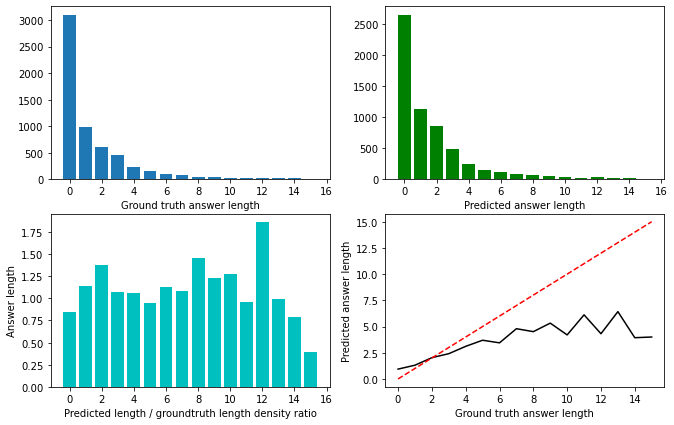

In [243]:
plt.figure(figsize=(11,7))
plt.subplot(2,2,1)
plt.bar(range(16), gt_count)
plt.xlabel('Ground truth answer length')

plt.subplot(2,2,2)
plt.bar(range(16), pd_count, color='g')
plt.xlabel('Predicted answer length')

plt.subplot(2,2,3)
plt.bar(range(16), pd_count/sum(pd_count)/gt_count*sum(gt_count), color='c')
plt.xlabel('Predicted length / groundtruth length density ratio')
plt.ylabel('Answer length')

plt.subplot(2,2,4)
plt.plot(range(16), df.groupby('groundtruth_len').mean().sort_index()[:16].predicted_len, 'k')
plt.plot(range(16), range(16), "r--")
plt.xlabel('Ground truth answer length')
plt.ylabel('Predicted answer length')
plt.savefig('fourplot')
